In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

% matplotlib inline

from event_context import EventContext
import event_generation
import encoding_schemes
from event_schemas import LinearMLP, BasicRNN, LinearRNN, BatchRNN
import hrr

Using TensorFlow backend.


## Transition Modeling

Because the encoding schemes translate scenes into vectors, any model that deals with vectors is a valid transition model. The objective of transition modeling is finding a model that can learn how scene vectors relate to each other; given a sequence of vectors representing scenes we've already seen, we want to predict the next one. We thus want a neural network architecture where the minimization of MSE leads to minimization of decoded error. 

The main design decisions are the architecture of the neural network used and how we train the network on observed events. For the former decision, a wide range of possible architectures can be evaluated, where the only requirement is that the network can train and predict on sequences of scenes, representing events. 

The latter design decision can be approached 3 ways. The first is online learning, where the network is updated after each observed event. The second is a batch generalization with batch size > 1, where events falling under the event schema are not trained on until enough are seen. Finally we can train in windows or recall earlier events during training of a newly observed event to learn the events in a fine-grained manner while ensuring that the gradients are not too noisy; this requires a map between each event schema to the events assigned to it, representing memory consolidation. 

## Scene Encoding

Basic structure of a scene has a subject, action, and object. For the sake of uniformity, property assignments occur within each scene, and do not constitute scenes in themselves; for instance, there aren't scenes like "Jerry becomes mad" or "Jerry is cold" because the assignment of abstract properties has a fundamentally different structure from action scenes. Instead the mad property can be incorporated as changes in the actor state; for instance the scene Jerry (not mad) loses money may lead to the scene Jerry (mad) hits table. While this yields a more uniform structure, there is the additional challenge of predicting both the change in actor properties due to actions and the chain of actions in a scene that depend on the actor state (in our example, the idea of "becoming mad" from "losing money" must be learned as an implicit intermediate step between "losing money" and "hitting table").

When measuring performance, we compare the decoded predicted vector with the ground truth fillers used to generate the vector. An important distinction when defining an error is whether we care about the getting the properties right, or whether the properties are just there to help decode the identity. For the sake of comparing different methods we just use the identity in this demo, but in future demos we will analyze performance of property prediction as well. We generate scenes using the following context.

In [2]:
properties = ['thirsty', 'violent', 'impatient', 'rich']
nouns = ['coffeeshop', 'coffee', 'line', 'store', 'shirt', 'mall']
verbs = ['enter', 'obey', 'cut', 'buy', 'confront', 'hit', 'apologize', 'leave', 'greet', 'try']

#### TODO: Baseline Model

A baseline of subject identity, action identity, object identity will be used to check how much of an improvement different property encoding methods yield. The way in which we incorporate properties is a crucial problem for encoding. Because properties determine the event transitions, we predict that without incorporating properties the testing error will be much higher than the training error. 

#### Causal Attention Model

The structure is:

subject_role $\times$ (noun_role $\times$ noun_identity + property_role $\times$ property_identity) + action_role $\times$ (verb_role $\times$ verb_identity + property_role $\times$ property_identity) + object_role $\times$ (noun_role $\times$ noun_identity + property_role $\times$ property_identity)

This structure models attention as it focuses on the attribute that drives prediction for the next step. It is more biologically reasonable than considering every property of an actor for each transition. However, this is an oversimplication of the encoding problem, because it assumes a priori that one knows how different properties lead to future actions. It makes more sense that these relations should be learned; this leads to a potential encoding scheme where the transition modeling first learns what properties are important using all-property encodings, but eventually transitions to only using a given type of encoding. 

This scheme also precludes prediction for multiple traits; there are a maximum of 8 possible decision paths at each time (the properties of the subject, action, and object) which may be too simplistic.

In [3]:
causal_attention_errors = []
for dim in range(20, 200):
    avg_errors = np.asarray([0.0, 0.0, 0.0])
    for trial in range(100): 
        context = EventContext(dim, nouns, verbs, properties)
        events, generating_fillers = event_generation.generate_evaluation_events(context, 'causal_attention')
        subject_error = 0.0
        action_error = 0.0
        object_error = 0.0
        count = 0
        for e in range(len(events)):
            for s in range(len(events[e])):
                count += 1
                scene = events[e][s]
                ground_truth = generating_fillers[e][s]
                se, ae, oe = encoding_schemes.causal_attention_errors(scene, ground_truth, context)
                subject_error += se
                action_error += ae
                object_error += oe
        avg_errors += np.asarray([subject_error, action_error, object_error])/count
    causal_attention_errors.append(avg_errors/100)

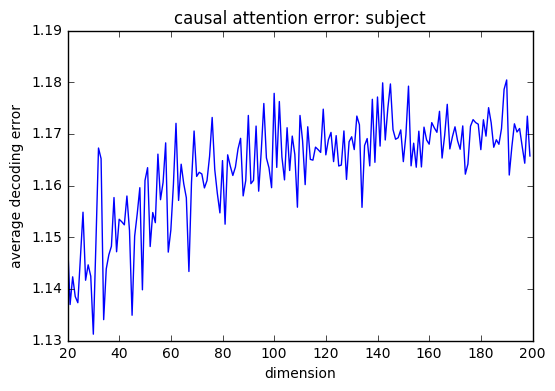

In [32]:
plt.plot(range(20, 200), np.asarray(causal_attention_errors)[:, 0])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("causal attention error: subject")

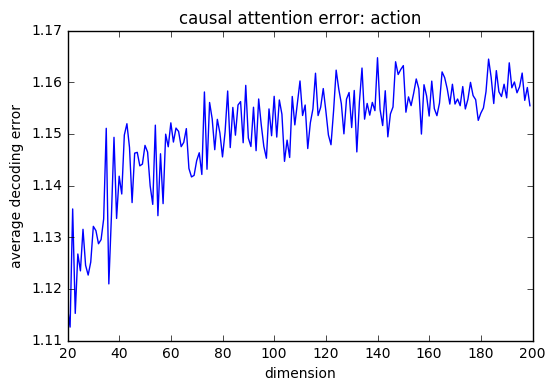

In [33]:
plt.plot(range(20, 200), np.asarray(causal_attention_errors)[:, 1])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("causal attention error: action")

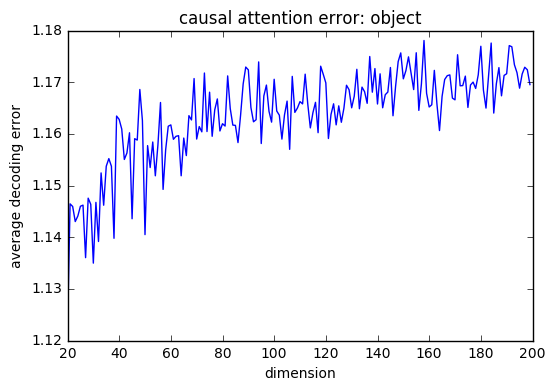

In [35]:
plt.plot(range(20, 200), np.asarray(causal_attention_errors)[:, 2])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("causal attention error: object")

In [8]:
dim = 150
context = EventContext(dim, nouns, verbs, properties)
training, training_fillers = event_generation.generate_evaluation_events(context, 'causal_attention', num_events = 5000, testing = False)
demo = LinearRNN(dim)

causal_attention_train_errors = []
causal_attention_test_errors = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        seen.append(scene)
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    
    if e % 50 == 0:
        training_eval, training_eval_fillers = event_generation.generate_evaluation_events(context, 'causal_attention', num_events = 100, testing = False)
        train_eval_errors = np.zeros(3)
        for t in range(len(training_eval)):
            train_seen = [training_eval[t][0]]
            error = np.zeros(3)
            for ts in range(len(training_eval[t])):
                train_prediction = hrr.normalize(demo.predict(train_seen))
                se, ae, oe = encoding_schemes.causal_attention_errors(train_prediction, training_eval_fillers[t][ts], context)
                error += np.asarray([se, ae, oe])
                train_seen.append(training_eval[t][ts])
            train_eval_errors += error/len(training_eval[t])
        causal_attention_train_errors.append(train_eval_errors)
                
        testing_eval, testing_eval_fillers = event_generation.generate_evaluation_events(context, 'causal_attention', num_events = 100, testing = True)
        test_eval_errors = np.zeros(3)
        for t in range(len(testing_eval)):
            test_seen = [testing_eval[t][0]]
            error = np.zeros(3)
            for ts in range(len(testing_eval[t])):
                test_prediction = hrr.normalize(demo.predict(test_seen))
                se, ae, oe = encoding_schemes.causal_attention_errors(test_prediction, testing_eval_fillers[t][ts], context)
                error += np.asarray([se, ae, oe])
                test_seen.append(testing_eval[t][ts])
            test_eval_errors += error/len(testing_eval[t])
        causal_attention_test_errors.append(test_eval_errors)

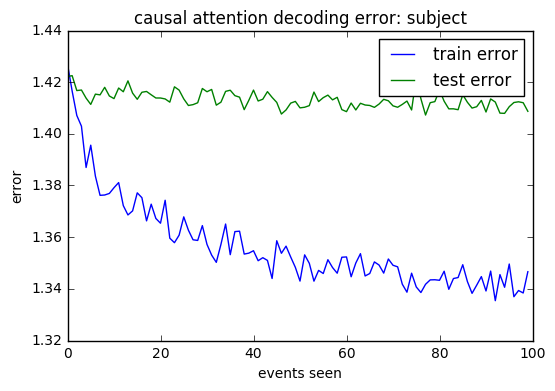

In [39]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,0])), np.asarray(causal_attention_train_errors)[:,0]/100, label = "train error")
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,0])), np.asarray(causal_attention_test_errors)[:,0]/100, label = "test error")
plt.legend()
plt.title("causal attention decoding error: subject")
plt.xlabel("events seen")
plt.ylabel("error")

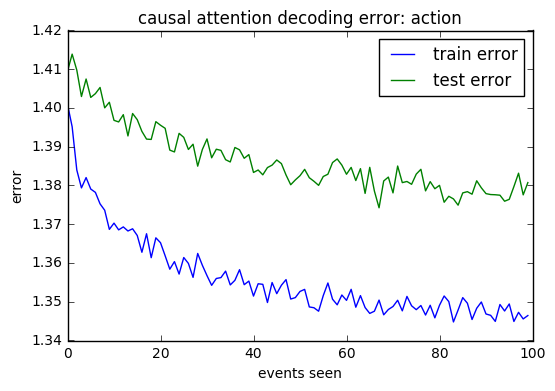

In [40]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,1])), np.asarray(causal_attention_train_errors)[:,1]/100, label = "train error")
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,1])), np.asarray(causal_attention_test_errors)[:,1]/100, label = "test error")
plt.legend()
plt.title("causal attention decoding error: action")
plt.xlabel("events seen")
plt.ylabel("error")

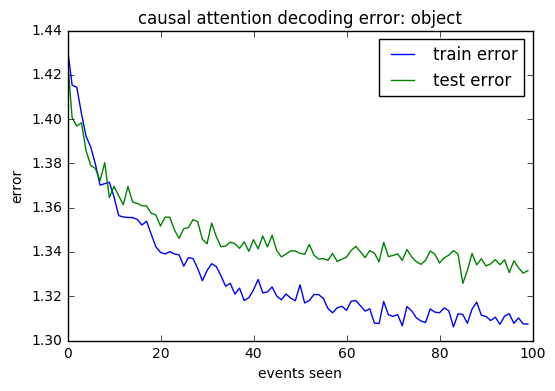

In [41]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,2])), np.asarray(causal_attention_train_errors)[:,2]/100, label = "train error")
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,2])), np.asarray(causal_attention_test_errors)[:,2]/100, label = "test error")
plt.legend()
plt.title("causal attention decoding error: object")
plt.xlabel("events seen")
plt.ylabel("error")

#### Trait Addition Model

The trait addition model adds each actor's properties to his/her identity vector in a sort of reverse engineering of semantic properties; for instance if John and James are both men their vectorizations should be more similar than those of John and Sarah. This includes temporary traits; if John and Sarah are both hungry they might take similar actions.

An issue is it is hard to recover the identity vector from the aggregate vector; even if the we maintain a list of linearly independent traits, reconstructing the identity from the traits is an intensive and noisy problem that may not be feasible. It is possible to maintain a new mapping at each point in time from the identity vector to the aggregate vector.

For now, we treat the aggregate vector as we would the identity in other models. This makes it easier to decode, as there is only one layer of decoding instead of 2, as in the other models. If using the aggregate vector as the identity is sufficient to the task, we can see how the other models compare. 

In [12]:
trait_addition_errors = []
for dim in range(20, 200):
    avg_errors = np.asarray([0.0, 0.0, 0.0])
    for trial in range(100): 
        context = EventContext(dim, nouns, verbs, properties)
        events, generating_fillers = event_generation.generate_evaluation_events(context, 'trait_addition')
        subject_error = 0.0
        action_error = 0.0
        object_error = 0.0
        count = 0
        for e in range(len(events)):
            for s in range(len(events[e])):
                count += 1
                scene = events[e][s]
                ground_truth = generating_fillers[e][s]
                se, ae, oe = encoding_schemes.trait_addition_errors(scene, ground_truth, context)
                subject_error += se
                action_error += ae
                object_error += oe
        avg_errors += np.asarray([subject_error, action_error, object_error])/count
    trait_addition_errors.append(avg_errors/100)

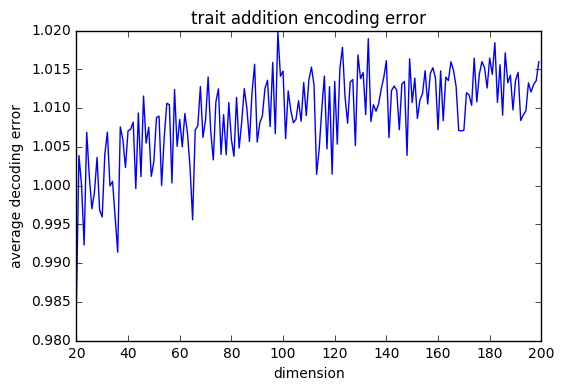

In [15]:
plt.plot(range(20, 200), np.asarray(trait_addition_errors)[:, 0])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("trait addition encoding error")

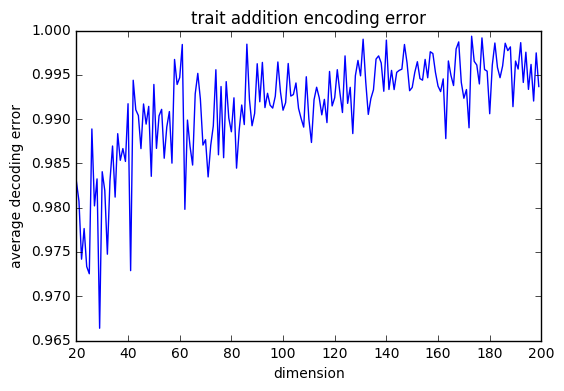

In [18]:
plt.plot(range(20, 200), np.asarray(trait_addition_errors)[:, 1])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("trait addition encoding error")

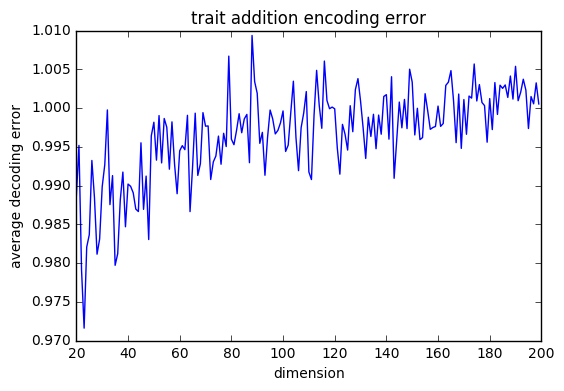

In [19]:
plt.plot(range(20, 200), np.asarray(trait_addition_errors)[:, 2])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("trait addition encoding error")

In [20]:
dim = 150
context = EventContext(dim, nouns, verbs, properties)
training, training_fillers = event_generation.generate_evaluation_events(context, 'trait_addition', num_events = 5000, testing = False)
demo = LinearRNN(dim)

trait_addition_train_errors = []
trait_addition_test_errors = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        seen.append(scene)
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    
    if e % 50 == 0:
        training_eval, training_eval_fillers = event_generation.generate_evaluation_events(context, 'trait_addition', num_events = 100, testing = False)
        train_eval_errors = np.zeros(3)
        for t in range(len(training_eval)):
            train_seen = [training_eval[t][0]]
            error = np.zeros(3)
            for ts in range(len(training_eval[t])):
                train_prediction = hrr.normalize(demo.predict(train_seen))
                se, ae, oe = encoding_schemes.trait_addition_errors(train_prediction, training_eval_fillers[t][ts], context)
                error += np.asarray([se, ae, oe])
                train_seen.append(training_eval[t][ts])
            train_eval_errors += error/len(training_eval[t])
        trait_addition_train_errors.append(train_eval_errors)
                
        testing_eval, testing_eval_fillers = event_generation.generate_evaluation_events(context, 'trait_addition', num_events = 100, testing = True)
        test_eval_errors = np.zeros(3)
        for t in range(len(testing_eval)):
            test_seen = [testing_eval[t][0]]
            error = np.zeros(3)
            for ts in range(len(testing_eval[t])):
                test_prediction = hrr.normalize(demo.predict(test_seen))
                se, ae, oe = encoding_schemes.trait_addition_errors(test_prediction, testing_eval_fillers[t][ts], context)
                error += np.asarray([se, ae, oe])
                test_seen.append(testing_eval[t][ts])
            test_eval_errors += error/len(testing_eval[t])
        trait_addition_test_errors.append(test_eval_errors)

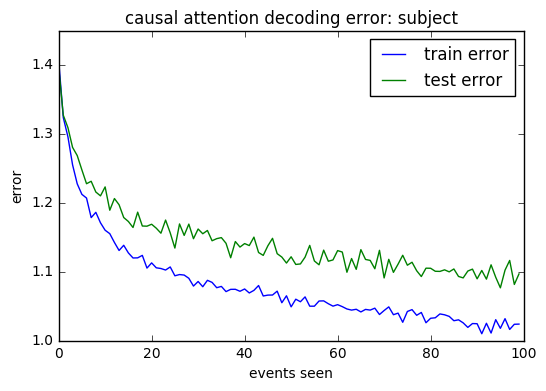

In [44]:
plt.plot(range(len(np.asarray(trait_addition_train_errors)[:,0])), np.asarray(trait_addition_train_errors)[:,0]/100, label = "train error")
plt.plot(range(len(np.asarray(trait_addition_test_errors)[:,0])), np.asarray(trait_addition_test_errors)[:,0]/100, label = "test error")
plt.legend()
plt.title("causal attention decoding error: subject")
plt.xlabel("events seen")
plt.ylabel("error")

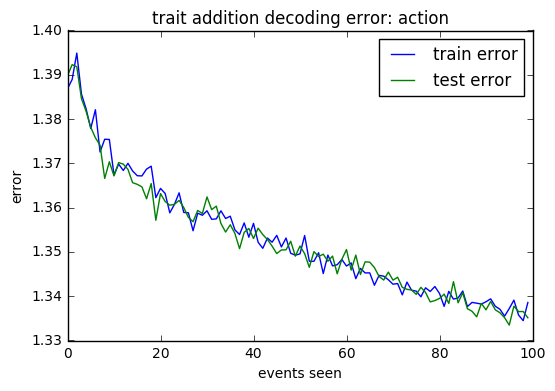

In [45]:
plt.plot(range(len(np.asarray(trait_addition_train_errors)[:,1])), np.asarray(trait_addition_train_errors)[:,1]/100, label = "train error")
plt.plot(range(len(np.asarray(trait_addition_test_errors)[:,1])), np.asarray(trait_addition_test_errors)[:,1]/100, label = "test error")
plt.legend()
plt.title("trait addition decoding error: action")
plt.xlabel("events seen")
plt.ylabel("error")

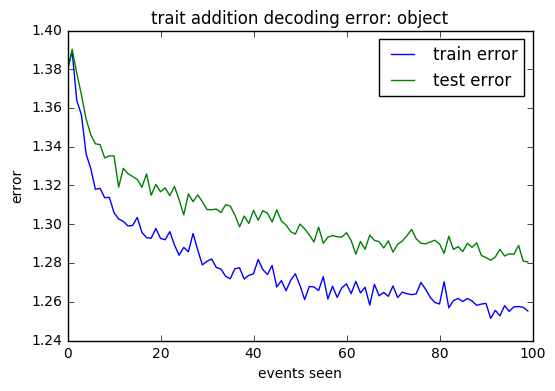

In [43]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,2])), np.asarray(trait_addition_train_errors)[:,2]/100, label = "train error")
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,2])), np.asarray(trait_addition_test_errors)[:,2]/100, label = "test error")
plt.legend()
plt.title("trait addition decoding error: object")
plt.xlabel("events seen")
plt.ylabel("error")

#### Boolean Binding Model

Here we hope to get a more easily decodable alternative to the above model. Instead of adding "hungry" to a person's identity, we bind "isHungry" and "TRUE". Each actor is thus noun_filler $\times$ noun_identity + $\sum$ property_boolean $\times$ [either the true vector or the false vector]

In [24]:
trait_boolean_binding_errors = []
for dim in range(20, 200):
    avg_errors = np.asarray([0.0, 0.0, 0.0])
    for trial in range(100): 
        context = EventContext(dim, nouns, verbs, properties)
        events, generating_fillers = event_generation.generate_evaluation_events(context, 'trait_boolean_binding')
        subject_error = 0.0
        action_error = 0.0
        object_error = 0.0
        count = 0
        for e in range(len(events)):
            for s in range(len(events[e])):
                count += 1
                scene = events[e][s]
                ground_truth = generating_fillers[e][s]
                se, ae, oe = encoding_schemes.trait_boolean_binding_errors(scene, ground_truth, context)
                subject_error += se
                action_error += ae
                object_error += oe
        avg_errors += np.asarray([subject_error, action_error, object_error])/count
    trait_boolean_binding_errors.append(avg_errors/100)

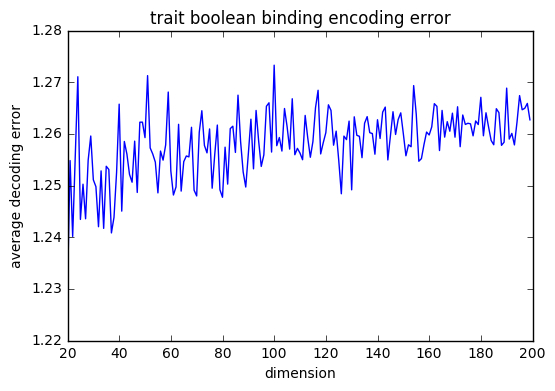

In [25]:
plt.plot(range(20, 200), np.asarray(trait_boolean_binding_errors)[:, 0])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("trait boolean binding encoding error")

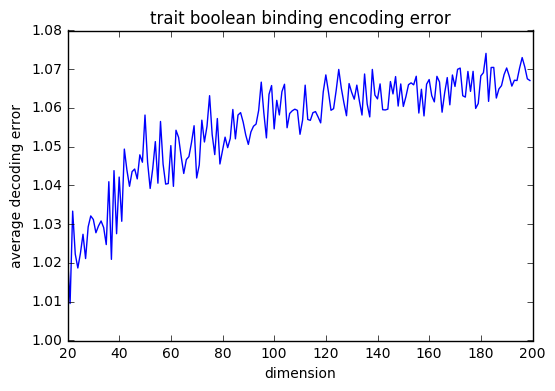

In [26]:
plt.plot(range(20, 200), np.asarray(trait_boolean_binding_errors)[:, 1])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("trait boolean binding encoding error")

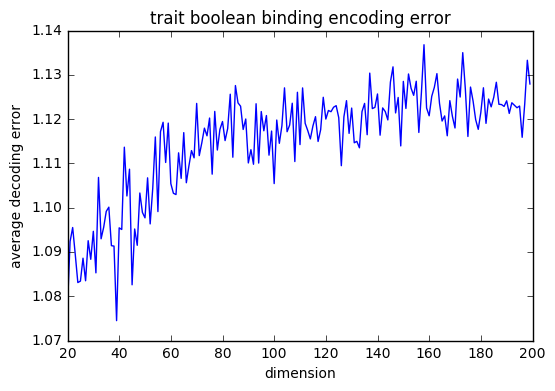

In [27]:
plt.plot(range(20, 200), np.asarray(trait_boolean_binding_errors)[:, 2])
plt.xlabel("dimension")
plt.ylabel("average decoding error")
plt.title("trait boolean binding encoding error")

In [28]:
dim = 150
context = EventContext(dim, nouns, verbs, properties)
training, training_fillers = event_generation.generate_evaluation_events(context, 'trait_boolean_binding', num_events = 5000, testing = False)
demo = LinearRNN(dim)

trait_boolean_binding_train_errors = []
trait_boolean_binding_test_errors = []
for e in range(len(training)):
    event = training[e]
    seen = [hrr.normalize(event[0])]
    for s in range(1, len(event)):
        scene = hrr.normalize(event[s])
        prediction = hrr.normalize(demo.predict(seen))
        seen.append(scene)
    demo.train_recurrent(list(map(lambda x : hrr.normalize(x), event)))
    
    if e % 50 == 0:
        training_eval, training_eval_fillers = event_generation.generate_evaluation_events(context, 'trait_boolean_binding', num_events = 100, testing = False)
        train_eval_errors = np.zeros(3)
        for t in range(len(training_eval)):
            train_seen = [training_eval[t][0]]
            error = np.zeros(3)
            for ts in range(len(training_eval[t])):
                train_prediction = hrr.normalize(demo.predict(train_seen))
                se, ae, oe = encoding_schemes.trait_boolean_binding_errors(train_prediction, training_eval_fillers[t][ts], context)
                error += np.asarray([se, ae, oe])
                train_seen.append(training_eval[t][ts])
            train_eval_errors += error/len(training_eval[t])
        trait_boolean_binding_train_errors.append(train_eval_errors)
                
        testing_eval, testing_eval_fillers = event_generation.generate_evaluation_events(context, 'trait_boolean_binding', num_events = 100, testing = True)
        test_eval_errors = np.zeros(3)
        for t in range(len(testing_eval)):
            test_seen = [testing_eval[t][0]]
            error = np.zeros(3)
            for ts in range(len(testing_eval[t])):
                test_prediction = hrr.normalize(demo.predict(test_seen))
                se, ae, oe = encoding_schemes.trait_boolean_binding_errors(test_prediction, testing_eval_fillers[t][ts], context)
                error += np.asarray([se, ae, oe])
                test_seen.append(testing_eval[t][ts])
            test_eval_errors += error/len(testing_eval[t])
        trait_boolean_binding_test_errors.append(test_eval_errors)

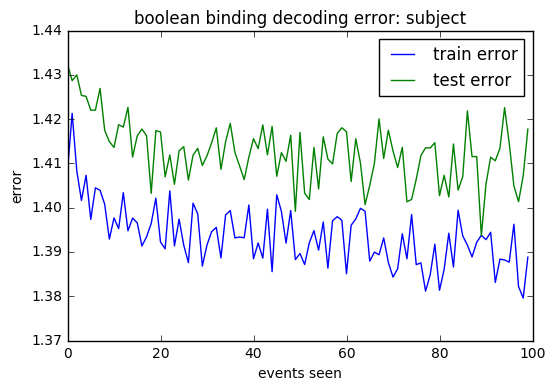

In [46]:
plt.plot(range(len(np.asarray(trait_boolean_binding_train_errors)[:,0])), np.asarray(trait_boolean_binding_train_errors)[:,0]/100, label = "train error")
plt.plot(range(len(np.asarray(trait_boolean_binding_test_errors)[:,0])), np.asarray(trait_boolean_binding_test_errors)[:,0]/100, label = "test error")
plt.legend()
plt.title("boolean binding decoding error: subject")
plt.xlabel("events seen")
plt.ylabel("error")

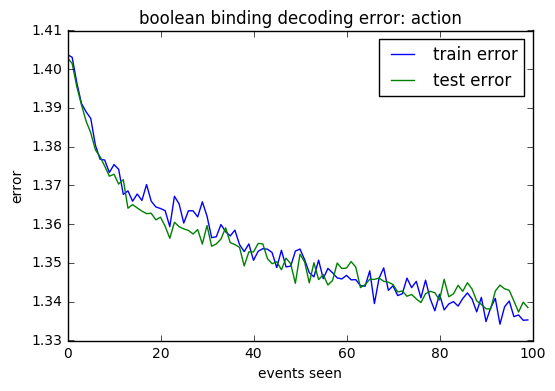

In [47]:
plt.plot(range(len(np.asarray(trait_boolean_binding_train_errors)[:,1])), np.asarray(trait_boolean_binding_train_errors)[:,1]/100, label = "train error")
plt.plot(range(len(np.asarray(trait_boolean_binding_test_errors)[:,1])), np.asarray(trait_boolean_binding_test_errors)[:,1]/100, label = "test error")
plt.legend()
plt.title("boolean binding decoding error: action")
plt.xlabel("events seen")
plt.ylabel("error")

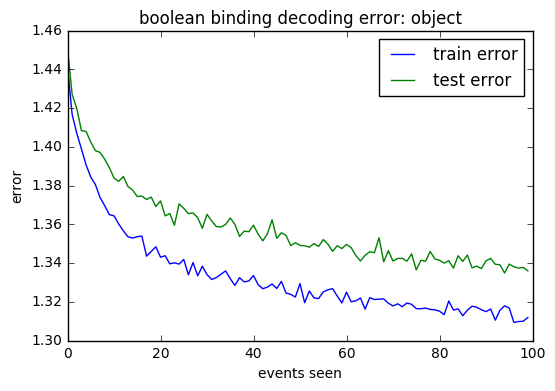

In [48]:
plt.plot(range(len(np.asarray(trait_boolean_binding_train_errors)[:,2])), np.asarray(trait_boolean_binding_train_errors)[:,2]/100, label = "train error")
plt.plot(range(len(np.asarray(trait_boolean_binding_test_errors)[:,2])), np.asarray(trait_boolean_binding_test_errors)[:,2]/100, label = "test error")
plt.legend()
plt.title("boolean binding decoding error: object")
plt.xlabel("events seen")
plt.ylabel("error")

#### Model Comparison: Training

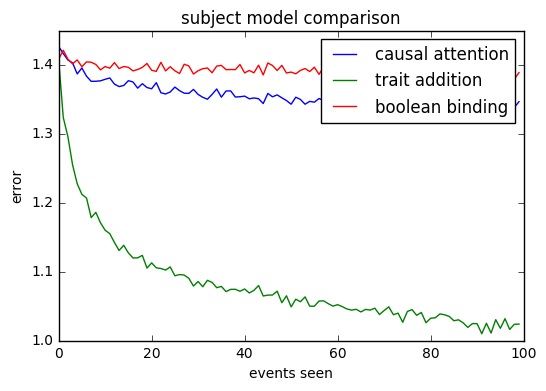

In [49]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,0])), np.asarray(causal_attention_train_errors)[:,0]/100, label = "causal attention")
plt.plot(range(len(np.asarray(trait_addition_train_errors)[:,0])), np.asarray(trait_addition_train_errors)[:,0]/100, label = "trait addition")
plt.plot(range(len(np.asarray(trait_boolean_binding_train_errors)[:,0])), np.asarray(trait_boolean_binding_train_errors)[:,0]/100, label = "boolean binding")
plt.legend()
plt.title("subject model comparison")
plt.xlabel("events seen")
plt.ylabel("error")

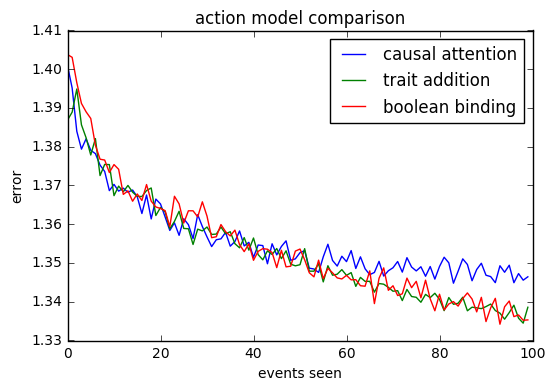

In [50]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,1])), np.asarray(causal_attention_train_errors)[:,1]/100, label = "causal attention")
plt.plot(range(len(np.asarray(trait_addition_train_errors)[:,1])), np.asarray(trait_addition_train_errors)[:,1]/100, label = "trait addition")
plt.plot(range(len(np.asarray(trait_boolean_binding_train_errors)[:,1])), np.asarray(trait_boolean_binding_train_errors)[:,1]/100, label = "boolean binding")
plt.legend()
plt.title("action model comparison")
plt.xlabel("events seen")
plt.ylabel("error")

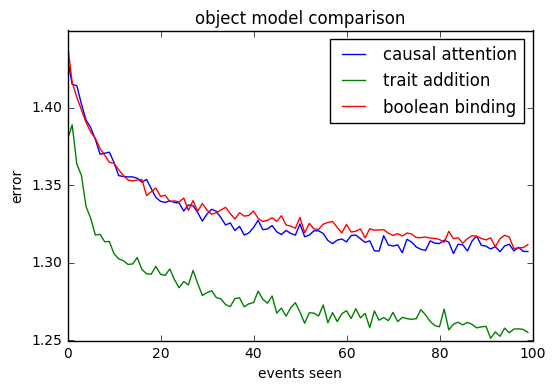

In [52]:
plt.plot(range(len(np.asarray(causal_attention_train_errors)[:,2])), np.asarray(causal_attention_train_errors)[:,2]/100, label = "causal attention")
plt.plot(range(len(np.asarray(trait_addition_train_errors)[:,2])), np.asarray(trait_addition_train_errors)[:,2]/100, label = "trait addition")
plt.plot(range(len(np.asarray(trait_boolean_binding_train_errors)[:,2])), np.asarray(trait_boolean_binding_train_errors)[:,2]/100, label = "boolean binding")
plt.legend()
plt.title("object model comparison")
plt.xlabel("events seen")
plt.ylabel("error")

#### Model Comparison: Testing

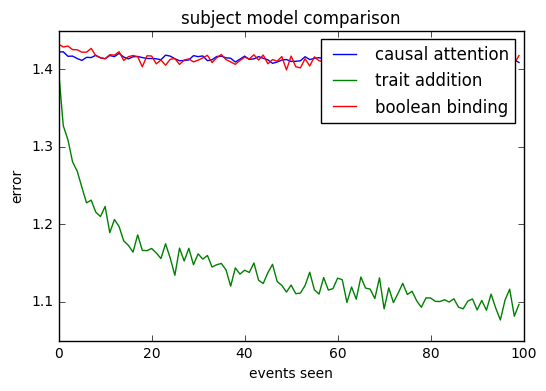

In [53]:
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,0])), np.asarray(causal_attention_test_errors)[:,0]/100, label = "causal attention")
plt.plot(range(len(np.asarray(trait_addition_test_errors)[:,0])), np.asarray(trait_addition_test_errors)[:,0]/100, label = "trait addition")
plt.plot(range(len(np.asarray(trait_boolean_binding_test_errors)[:,0])), np.asarray(trait_boolean_binding_test_errors)[:,0]/100, label = "boolean binding")
plt.legend()
plt.title("subject model comparison")
plt.xlabel("events seen")
plt.ylabel("error")

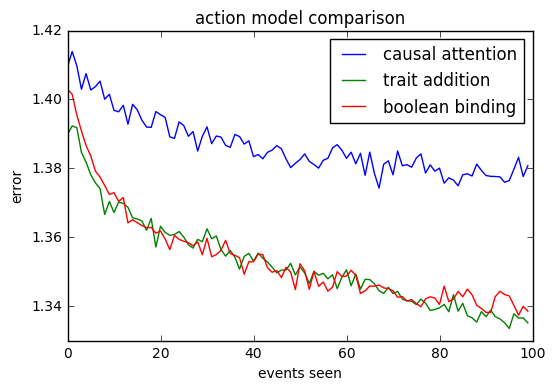

In [54]:
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,1])), np.asarray(causal_attention_test_errors)[:,1]/100, label = "causal attention")
plt.plot(range(len(np.asarray(trait_addition_test_errors)[:,1])), np.asarray(trait_addition_test_errors)[:,1]/100, label = "trait addition")
plt.plot(range(len(np.asarray(trait_boolean_binding_test_errors)[:,1])), np.asarray(trait_boolean_binding_test_errors)[:,1]/100, label = "boolean binding")
plt.legend()
plt.title("action model comparison")
plt.xlabel("events seen")
plt.ylabel("error")

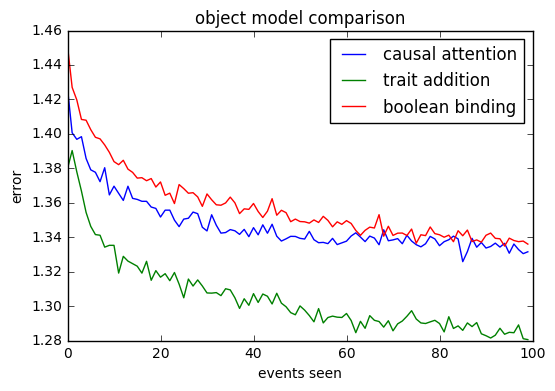

In [55]:
plt.plot(range(len(np.asarray(causal_attention_test_errors)[:,2])), np.asarray(causal_attention_test_errors)[:,2]/100, label = "causal attention")
plt.plot(range(len(np.asarray(trait_addition_test_errors)[:,2])), np.asarray(trait_addition_test_errors)[:,2]/100, label = "trait addition")
plt.plot(range(len(np.asarray(trait_boolean_binding_test_errors)[:,2])), np.asarray(trait_boolean_binding_test_errors)[:,2]/100, label = "boolean binding")
plt.legend()
plt.title("object model comparison")
plt.xlabel("events seen")
plt.ylabel("error")